<a href="https://colab.research.google.com/github/Tomjaz/amazon-beauty-products-recommendation/blob/main/recomendation_review3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from IPython.core.display import HTML

%matplotlib inline

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357270 sha256=e26623b2dfd005775f6d7ede892fcd2269cb98384e99d19d8f2f4a2fc0455ee0
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
df = pd.read_json("/content/reviews_Beauty_5.json.gz",lines=True)

In [ ]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"


In [ ]:
#checking for nulls
df.isna().sum()

,0
reviewerID,0
asin,0
reviewerName,1386
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0


In [ ]:
#1386 reviewerNames left blank; we will not need reviewerName since utilizing reviewerID
#checking that all needed information is provided when reviewerName is NaN

In [ ]:
df[df['reviewerName'].isnull()]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
8,A3LMILRM9OC3SA,9759091062,NaN,"[0, 0]",Did nothing for me. Stings when I put it on. I...,2,"no Lightening, no Brightening,......NOTHING",1405209600,"07 13, 2014"
1790,AK1H26O8DLMNN,B0000535UM,NaN,"[0, 0]",The first thickening shampoo that works on my ...,5,Actually works,1405123200,"07 12, 2014"
2242,APTLHR9PHGPXN,B00005NAOD,NaN,"[0, 0]","Kind of drying, not moisturizing. Kind of disa...",2,Inexpensive and feels that wY,1405209600,"07 13, 2014"
2304,AQWX644AFUFFK,B00005NFBD,NaN,"[0, 0]","This is just ok. For one, I found this in a st...",3,"Ok, nothing amazing",1405468800,"07 16, 2014"
3651,A43K5ZRQ87TO6,B00008PC1O,NaN,"[0, 0]",Works well and easy to use!,5,Five Stars,1405296000,"07 14, 2014"
...,...,...,...,...,...,...,...,...,...
197192,A1Z3AV93ONK5VF,B00KAL5JAU,NaN,"[0, 0]",We already had the Dead Sea Shampoo by Adovia ...,5,"Non greasy, silky shiny hair",1401235200,"05 28, 2014"
197193,A184I8GT3BHZQV,B00KAL5JAU,NaN,"[0, 1]",&#60;a href=&#34;http://www.tomoson.com/?code=...,5,Dead Sea Salt hair conditioner,1403568000,"06 24, 2014"
197194,A8C9EJORQD23,B00KAL5JAU,NaN,"[0, 1]",I use this with the Adovia shampoo I mention a...,5,Adovia does natural right!,1402272000,"06 9, 2014"
198446,A2PIGZCDGM4NJ7,B00L5JHZJO,NaN,"[10, 11]","This is a horrible product, most of the review...",1,Bad Product,1404864000,"07 9, 2014"


In [ ]:
#checking that all reviewers have completed at least 5 reviews

In [ ]:
df.reviewerID.value_counts()

,count
reviewerID,
A2V5R832QCSOMX,204
ALNFHVS3SC4FV,192
AKMEY1BSHSDG7,182
A3KEZLJ59C1JVH,154
ALQGOMOY1F5X9,150
...,...
A2E1P9J6TTHLS6,5
A1F09METOUKOCH,5
AJDOMSU08A256,5


In [ ]:
#YAY! all reviewerIDs have value of at least 5, total of 22,363 reviewers

In [ ]:
#checking that all products have been reviewed at least 5 times

In [ ]:
df.asin.value_counts()

,count
asin,
B004OHQR1Q,431
B0043OYFKU,403
B0069FDR96,391
B000ZMBSPE,389
B00150LT40,329
...,...
B0084OCSAE,5
B0084SSLVK,5
B0084T82A4,5


In [ ]:
#YAY! all products have at least 5 reviews, total of 12,101 different products

In [ ]:
#looking at ratings distribution

In [ ]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

<ipython-input-11-e79a113f23eb>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data.values, palette="viridis")


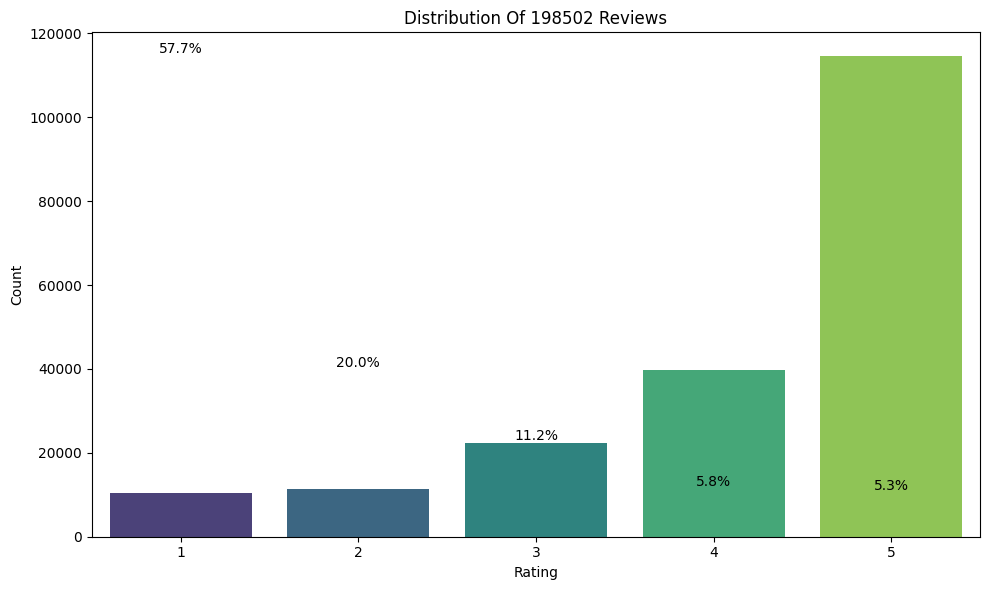

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate data for plotting
data = df['overall'].value_counts().sort_index(ascending=False)

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create the bar plot using seaborn
ax = sns.barplot(x=data.index, y=data.values, palette="viridis")

# Add percentage labels on the bars
for i, val in enumerate(data.values):
    ax.text(i, val + 0.5, '{:.1f}%'.format(val / df.shape[0] * 100),
            ha='center', va='bottom', color='black')

# Customize plot
plt.title(f'Distribution Of {df.shape[0]} Reviews')
plt.xlabel('Rating')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#we see a majority of our ratings are 5s, which could impact our system

In [ ]:
#exploring number of ratings per product

In [ ]:
data = df.groupby('asin')['overall'].count().clip(upper=50)

In [ ]:
data

,overall
asin,
7806397051,8
9759091062,11
9788072216,5
9790790961,6
9790794231,5
...,...
B00L5KTZ0K,15
B00L6Q3BH6,5
B00LCEROA2,9


In [ ]:
data = df.groupby('asin')['overall'].count()
data

,overall
asin,
7806397051,8
9759091062,11
9788072216,5
9790790961,6
9790794231,5
...,...
B00L5KTZ0K,15
B00L6Q3BH6,5
B00LCEROA2,9


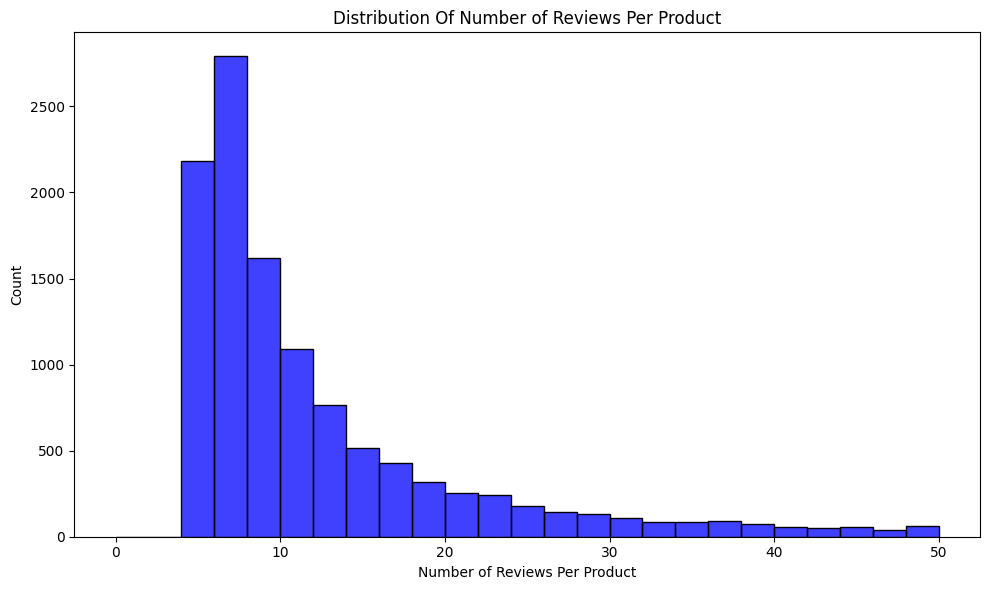

<Figure size 640x480 with 0 Axes>

In [ ]:
# Data for plotting
data = df.groupby('asin')['overall'].count()

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the histogram using seaborn or matplotlib
sns.histplot(data.values, bins=range(0, 52, 2), color="blue", kde=False)

# Customize the plot
plt.title('Distribution Of Number of Reviews Per Product')
plt.xlabel('Number of Reviews Per Product')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

# Saving the plot to a file as PNG
plt.savefig("images/reviews_per_product.png", format='png', dpi=500)

In [ ]:
#We see a majority of our projects have 10 or less ratings

In [ ]:
#exploring ratings distribution by user

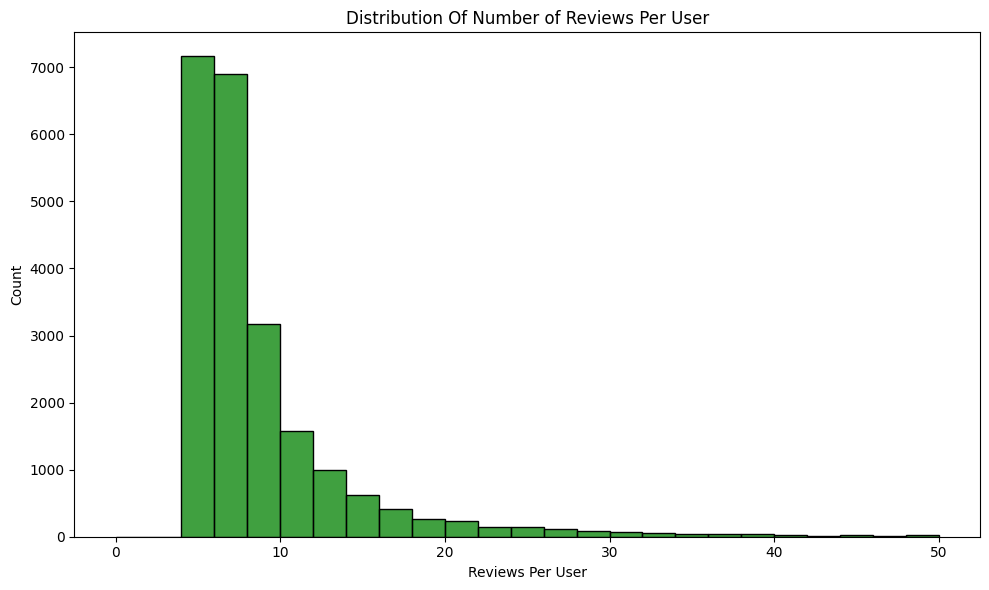

<Figure size 640x480 with 0 Axes>

In [ ]:
# Data for plotting
data = df.groupby('reviewerID')['overall'].count()

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the histogram using seaborn
sns.histplot(data.values, bins=range(0, 52, 2), color="green", kde=False)

# Customize the plot
plt.title('Distribution Of Number of Reviews Per User')
plt.xlabel('Reviews Per User')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

# Saving the plot to a file as PNG
plt.savefig("images/reviews_per_user.png", format='png', dpi=500)

In [ ]:
#we see most users rated under 10 products

In [ ]:
lower_rating = df.overall.min()
upper_rating = df.overall.max()

In [ ]:
#Confirming our review range is 1 to 5

In [ ]:
print('Review range: {0} to {1}'.format(lower_rating, upper_rating))

Review range: 1 to 5


In [ ]:
#Creating dataframe with appropriate columns to run through surprise

In [ ]:
surprise_df = df[['reviewerID', 'asin', 'overall']]
surprise_df

,reviewerID,asin,overall
0,A1YJEY40YUW4SE,7806397051,1
1,A60XNB876KYML,7806397051,3
2,A3G6XNM240RMWA,7806397051,4
3,A1PQFP6SAJ6D80,7806397051,2
4,A38FVHZTNQ271F,7806397051,3
...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,5
198498,A1UQBFCERIP7VJ,B00LLPT4HI,5
198499,A35Q0RBM3YNQNF,B00LLPT4HI,5
198500,A3LGT6UZL99IW1,B00LLPT4HI,5


In [ ]:
#Checking average rating user to see if there are users who rate everything 1 or 5

In [ ]:
avg_rating_user = df.groupby("reviewerID")["overall"].mean().sort_values() # Removing "overall" as it is not needed for a series
avg_rating_user

,overall
reviewerID,
A1W522Z24EPBJB,1.0
A2DPSPXFJ507C0,1.0
A1GQLVT0SWAWU,1.0
A1KLA02LZXAT46,1.0
A2MHHSACEJANSX,1.0
...,...
A15QGN6UXJVW9G,5.0
ANOJX4RAUJ9HL,5.0
A2RJT3IE2T6KXJ,5.0


In [ ]:
low_rating_user = avg_rating_user[avg_rating_user == 1.0]
low_rating_user

,overall
reviewerID,
A1W522Z24EPBJB,1.0
A2DPSPXFJ507C0,1.0
A1GQLVT0SWAWU,1.0
A1KLA02LZXAT46,1.0
A2MHHSACEJANSX,1.0
A2RJTIE73NPN3C,1.0
ASWIC85F71H4J,1.0
A2TBE0N8JN6H4K,1.0
A1GPPMHYM6SMEW,1.0


In [ ]:
#only 9 users have rated every product a 1

In [ ]:
high_rating_user = avg_rating_user[avg_rating_user == 5.0] # Removing ["overall"] as it is not needed for a series that is already based on the average "overall" rating
high_rating_user

,overall
reviewerID,
A2FINIRQNXOTI,5.0
ATWS89FH6Y6S4,5.0
A16Q479PYT0G6N,5.0
A3OKW5VRXZG3OQ,5.0
A3O9Q3154FPZLL,5.0
...,...
A15QGN6UXJVW9G,5.0
ANOJX4RAUJ9HL,5.0
A2RJT3IE2T6KXJ,5.0


In [ ]:
#2822 users have rated every product a 5

In [ ]:
#we decide to keep these users in our final dataset but will not use them to test our model for recommendations

### Exploring Meta Data

In [ ]:
#Import our meta data
import gzip
Svd=0.17823
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
meta_data_df = getDF("/content/meta_Beauty.json.gz")
meta_data_df

,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin suc...",Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,http://ecx.images-amazon.com/images/I/41DecrGO...,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...,Eco Friendly Ecotools Quality Natural Bamboo C...,http://ecx.images-amazon.com/images/I/51L%2BzY...,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha b...",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1...,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring...,Hello Kitty Lustre Lipstick (See sellers comme...,http://ecx.images-amazon.com/images/I/31u6Hrzk...,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) cre...",Stephanie Johnson Mermaid Round Snap Mirror,http://ecx.images-amazon.com/images/I/41y2%2BF...,NaN,"[[Beauty, Tools & Accessories, Mirrors, Makeup...",19.98,NaN,NaN
...,...,...,...,...,...,...,...,...,...
259199,B00LP2YB8E,Color: White\nFullness72 inches\nCenter Gather...,2t 2t Edge Crystal Rhinestones Bridal Wedding ...,http://ecx.images-amazon.com/images/I/41E630m-...,NaN,"[[Beauty, Hair Care, Styling Tools, Styling Ac...",NaN,NaN,NaN
259200,B00LOS7MEE,"The secret to long lasting colors, healthy nai...",French Manicure Gel Nail Polish Set - &quot;Se...,http://ecx.images-amazon.com/images/I/41skHL1O...,{'Beauty': 108820},"[[Beauty, Makeup, Nails, Nail Polish]]",NaN,"{'also_viewed': ['B0057JCYYE', 'B00LMXHR1Y', '...",NaN
259201,B00LPVG6V0,ResQ Organics Face & Body Wash - With Aloe Ver...,ResQ Organics Face &amp; Body Wash - Aloe Vera...,http://ecx.images-amazon.com/images/I/31C1w4Ku...,NaN,"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
259202,B00LTDUHJQ,Color: White\n2 Tier \nFullness 72 inches\nSew...,2 Tier Tulle Elbow Wedding Veil with Ribbon Ed...,http://ecx.images-amazon.com/images/I/51%2B%2B...,NaN,"[[Beauty, Hair Care, Styling Tools, Styling Ac...",NaN,NaN,NaN


In [ ]:
meta_data_df.isna().sum()

,0
asin,0
description,24707
title,444
imUrl,88
salesRank,5188
categories,0
price,69274
related,51350
brand,131038


In [ ]:
#exploring NaN and deciding which data is helpful to return to our users for recommendations

In [ ]:
meta_data_df.shape
baselinee2=0.19976

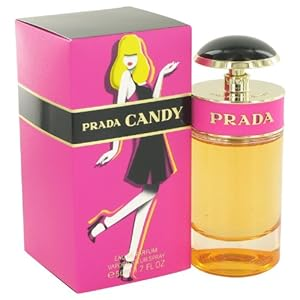

In [ ]:
from IPython import display
Score=0.21524
display.Image(meta_data_df.loc[192]["imUrl"])
#display.Image(meta_data_df_cleaned.loc[259179]["imUrl"])

In [ ]:
meta_data_df.price.describe()

,price
count,189930.000000
mean,24.878165
std,33.431190
min,0.010000
25%,8.240000
50%,15.690000
75%,29.300000
max,999.990000


In [ ]:
meta_data_df[meta_data_df['price'] == 999.99]

,asin,description,title,imUrl,salesRank,categories,price,related,brand
197364,B009PQIAL6,This beautifully sculpted and gracefully desig...,&quot;Vernet&quot; Black Dual Dryer Chair With...,http://ecx.images-amazon.com/images/I/41ks5sFA...,{'Beauty': 582815},"[[Beauty, Tools & Accessories, Nail Tools, Nai...",999.99,"{'also_viewed': ['B004O4N4OW', 'B009ZHVQYI', '...",NaN


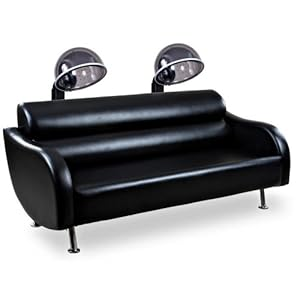

In [ ]:
display.Image(meta_data_df.loc[197364]["imUrl"])

In [ ]:
meta_data_df.rename(columns={'description':'Description', 'title': 'Product Name', 'asin':'ASIN', 'imUrl':'Image'}, inplace=True)
sgd_baselinee=0.15432

In [ ]:
meta_data_df.head(3)

,ASIN,Description,Product Name,Image,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin suc...",Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,http://ecx.images-amazon.com/images/I/41DecrGO...,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...,Eco Friendly Ecotools Quality Natural Bamboo C...,http://ecx.images-amazon.com/images/I/51L%2BzY...,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha b...",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1...,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",NaN,NaN,NaN


In [ ]:
meta_data_df.isna().sum()

,0
ASIN,0
Description,24707
Product Name,444
Image,88
salesRank,5188
categories,0
price,69274
related,51350
brand,131038


In [ ]:
#dropping brand due to large # of nulls
meta_data_df.drop(columns=['brand'], inplace=True)

## Methods

In [ ]:
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_df, reader)

trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=23)

In [ ]:
surprise_data

In [ ]:
# How many users and items are in the trainset
print('Number of users: ', trainset.n_users, '\n')
baselinee=0.21789
print('Number of items: ', trainset.n_items, '\n')

Number of users:  22359 

Number of items:  12101 



### Dummy Model

In [ ]:
baseline = NormalPredictor()
baseline.fit(trainset)

In [ ]:
predictions = baseline.test(testset)

In [ ]:
baseline = accuracy.mse(predictions)


MSE: 2.2428


In [ ]:
print("RMSE:",baselinee)

RMSE: 0.21789


### Baseline Models

In [ ]:
baseline2 = BaselineOnly()
baseline2.fit(trainset)

Estimating biases using als...


In [ ]:
predictions2 = baseline2.test(testset)

In [ ]:
baseline2 = accuracy.rmse(predictions2)

In [ ]:
print("RMSE:",baselinee2)

RMSE: 0.19976


In [ ]:
als_options = {'method': 'als',
               }
als_baseline = BaselineOnly(bsl_options=als_options)

In [ ]:
als_baseline.fit(trainset)

Estimating biases using als...


In [ ]:
predictions = als_baseline.test(testset)

In [ ]:
als_baseline = accuracy.mae(predictions)

In [ ]:
sgd_options = {'method': 'sgd',
               }
sgd_baseline = BaselineOnly(bsl_options=sgd_options)

In [ ]:
sgd_baseline.fit(trainset)

Estimating biases using sgd...


In [ ]:
predictions = sgd_baseline.test(testset)

In [ ]:
sgd_baseline = accuracy.rmse(predictions)

In [ ]:
print("RMSE",sgd_baselinee)

RMSE 0.15432


### SVD Model Exploration

In [ ]:
svd = SVD(random_state=42)
svd.fit(trainset)
predictions = svd.test(testset)
score=accuracy.rmse(predictions)


In [ ]:
print("RMSE:",Score)

RMSE: 0.21524


In [ ]:
#Checking to see estimated rating for 2 user/product combinations

In [ ]:
svd.predict('A1YJEY40YUW4SE', 'B00LLPT4HI')

Prediction(uid='A1YJEY40YUW4SE', iid='B00LLPT4HI', r_ui=None, est=4.41104541567184, details={'was_impossible': False})

In [ ]:
svd.predict('A2BLFCOPSMBOZ9', '7806397051')

Prediction(uid='A2BLFCOPSMBOZ9', iid='7806397051', r_ui=None, est=3.774499861592997, details={'was_impossible': False})

In [ ]:
cv_svd_baseline = cross_validate(svd, surprise_data)

In [ ]:
cv_svd_baseline

{'test_rmse': array([1.09569079, 1.08737839, 1.0887515 , 1.09295952, 1.09091349]),
 'test_mae': array([0.83910808, 0.83242972, 0.83573168, 0.83828263, 0.83670712]),
 'fit_time': (2.717909097671509,
  2.6942026615142822,
  3.591012716293335,
  2.687141180038452,
  2.7309796810150146),
 'test_time': (1.159372329711914,
  0.27112674713134766,
  0.2837104797363281,
  0.21797728538513184,
  0.21918821334838867)}

In [ ]:
#Hold out 10% of data for validation
#Create a new surpise data class
svd_data = Dataset.load_from_df(surprise_df, reader)
raw_ratings_svd = svd_data.raw_ratings
# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings_svd))
A_raw_ratings_svd = raw_ratings_svd[:threshold]
B_raw_ratings_svd = raw_ratings_svd[threshold:]

In [ ]:
# svd_data is now the set A
svd_data.raw_ratings = A_raw_ratings_svd

In [ ]:
#Create a param grid for grid search
SVD_parm_grid = {'n_factors':[20,50,100,150],'n_epochs':[10,20,30],'biased':[True,False]}

In [ ]:
svd2 = SVD(n_factors=20, n_epochs=20, biased=True, random_state=42)
svd2.fit(trainset)
predictions = svd2.test(testset)
svd=accuracy.rmse(predictions)

In [ ]:
print("RMSE:",Svd)

RMSE: 0.17823


### SVPpp Model Exploration


In [ ]:
svdpp = SVDpp(random_state=23)
svdpp.fit(trainset)
predictions = svdpp.test(testset)
svdp=accuracy.rmse(predictions)

In [ ]:
print("RMSE:",svdp)

RMSE: 0.21342


## Final Collaborative Filtering Models


In [ ]:
trainset_full = surprise_data.build_full_trainset()

In [ ]:
trainset_full

In [ ]:
best_model = SVD(n_factors=2, n_epochs=20, biased=True, random_state=23)
best_model.fit(trainset_full)

In [ ]:
## Subset data frame to show reviewers the products they have rated
df_prior_ratings = pd.DataFrame(df.set_index("reviewerID"))
svdp=0.21342
df_prior_ratings.drop(columns= ["reviewerName", "helpful", "reviewText", "overall", "summary", "unixReviewTime", "reviewTime"], inplace=True)
df_prior_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198502 entries, A1YJEY40YUW4SE to A3UJRNI8UR4871
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   asin    198502 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
def buyer_recommended_products():
    pd.set_option('display.max_colwidth', None)
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))

    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewed = not_reviewed[['ASIN','Product Name', 'Description', 'Image', 'predicted_rating']].head(n_recs)

 #Converting links to html tags
    def path_to_image_html(path):
        return '<img src="'+ path + '" width="60" >'


    return HTML(not_reviewed.to_html(escape=False, formatters=dict(Image=path_to_image_html)))




## Creating a Recommendation System with an option to add Category of Product

In [ ]:
subcategories = []
for row in meta_data_df["categories"]:
    value = row[0][1]
    if value not in subcategories:
        subcategories.append(value)
subcategories

['Skin Care',
 'Tools & Accessories',
 'Makeup',
 'Hair Care',
 'Bath & Body',
 'Fragrance',
 'Fan Shop',
 'Snow Sports',
 'Kitchen & Dining',
 'Health Care',
 'Stationery & Party Supplies',
 'Storage & Organization',
 'Baby & Child Care',
 'Personal Care',
 'Household Supplies',
 'Accessories',
 'Hardware']

In [ ]:
#create a function to extract subcategory level 1 from categories
def get_subcategory(cat):
    value = cat[0][1]
    return(value)

In [ ]:
#Create a new column in our meta data df called "sub_cat" containing sub category info
meta_data_df["sub_cat"] = meta_data_df["categories"].apply(get_subcategory)

In [ ]:
def buyer_recommended_category_products():
    pd.set_option('display.max_colwidth', None)
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))
    #request_category from subcategories
    request_category = input("Which category of beauty to recommend buyer? ")

    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)
    not_reviewed = not_reviewed[not_reviewed["sub_cat"]==request_category]
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewed = not_reviewed[['ASIN','Product Name', 'Description', 'Image', 'predicted_rating']].head(n_recs)

    #Converting links to html tags
    def path_to_image_html(path):
        return '<img src="'+ path + '" width="60" >'


    return HTML(not_reviewed.to_html(escape=False, formatters=dict(Image=path_to_image_html)))

In [ ]:
buyer_recommended_category_products()

reviewerID: A1YJEY40YUW4SE
How many recommendations? 2
Which category of beauty to recommend buyer? Makeup


,ASIN,Product Name,Description,Image,predicted_rating
200566,B00A1Y177A,"Color Club Halographic Hues Nail Polish, Light Green, Cloud Nine, .05 Ounce",A linear holographic nail polish that will take you to cloud nine. A halographic nail polish that will bring a touch of heaven to everything you do. Favorite nail polish for celebrity manicurists and nail color fans worldwide.,,4.610516
195484,B009JKDCEI,"OPI Holiday Nail Lacquer Collection Limited Edition, Goldeneye, 0.5 Fluid Ounce","OPI limited edition holiday 2012 Skyfall 007 nail lacquer collection celebrates 50 year anniversary of james bond 007 and the release of the new bond movies, Skyfall. The collection consists of 12 dazzling new shades for the holiday.",,4.523929
